# <font color='green'> Spark <font color='black'> to <font color='blue'> CAS <font color='black'> Cookbook

1. This demonstration serves as a syntax comparison between Spark and CAS using each respective Python API. 
2. This cookbook style approach makes it simple to transition a Spark notebook to CAS and create SAS DATA Step Score Code deployment artifacts.

# Data

A financial services company offers a home equity line of credit to its clients. The
company has extended several thousand lines of credit in the past, and many of these
accepted applicants (approximately 20%) have defaulted on their loans. The company wants to build a model
to predict whether an applicant will default. After analyzing the data, the company selected a subset of 12 predictor
variables to model whether each applicant defaulted. The response variable
(BAD) indicates whether an applicant defaulted on the home equity line of credit.
These variables, along with their model role, measurement level, and description, are
shown in the following table from the **HMEQ** data set.

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

# Documentation

<div class="alert-success">
Spark
</div>

[Spark API Reference](https://spark.apache.org/docs/latest/api/python/reference/index.html)

<div class="alert-info">
CAS
</div>

[CAS API Reference](https://developer.sas.com/apis/swat/python/1.0.0/api.html)

[CAS Action Sets](https://go.documentation.sas.com/doc/en/pgmsascdc/v_030/allprodsactions/actionSetsByName.htm)

# Load Packages

<div class="alert-success">
Spark
</div>

In [1]:
import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, isnan, when, count, mean, sqrt, count_distinct, udf, lit
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

<div class="alert-info">
CAS
</div>

In [2]:
import swat

<div class="alert-warning">
Local
</div>

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
%matplotlib inline
import csv
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Create Sessions

<div class="alert-success">
Spark
</div>

In [4]:
spark = SparkSession.builder.appName("Practice").getOrCreate()
spark

<div class="alert-info">
CAS
</div>

In [5]:
conn = swat.CAS("server", 8777, "student", "Metadata0", protocol="http")

In [6]:
action_sets = ['simple','sampling','dataStep','fedSql','regression','decisionTree','autotune','percentile']
for action_set in action_sets:
    conn.loadActionSet(action_set)

NOTE: Added action set 'simple'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'dataStep'.
NOTE: Added action set 'fedSql'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'percentile'.


# Load Data

<div class="alert-success">
Spark
</div>

In [7]:
df_spark = spark.read.csv("D:\\Workshop\\winsas\\VOSI\\hmeq.csv", header=True, inferSchema=True)

<div class="alert-info">
CAS
</div>

In [8]:
df_cas = conn.read_csv("D:\\Workshop\\winsas\\VOSI\\hmeq.csv", casout = dict(name="hmeq", replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(student).
NOTE: The table HMEQ has been created in caslib CASUSER(student) from binary data uploaded to Cloud Analytic Services.


# View In-Memory Data Tables

<div class="alert-success">
Spark
</div>

In [9]:
[k for (k, v) in globals().items() if isinstance(v, DataFrame)]

['df_spark']

<div class="alert-info">
CAS
</div>

In [10]:
conn.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,HMEQ,5960,13,0,utf-8,2022-09-01T12:07:26-04:00,2022-09-01T12:07:26-04:00,2022-09-01T12:07:26-04:00,UTF8,1.977668e+09,1.977668e+09,1.977668e+09,0,0,0,0,,,0,student,,2022-09-01T12:07:26-04:00,1.977668e+09


# DataFrame Reference

<div class="alert-success">
Spark
</div>

In [11]:
type(df_spark)

pyspark.sql.dataframe.DataFrame

<div class="alert-info">
CAS
</div>

In [12]:
type(df_cas)

swat.cas.table.CASTable

# Explore Data

<div class="alert-success">
Spark
</div>

In [13]:
df_spark.printSchema()

root
 |-- BAD: integer (nullable = true)
 |-- LOAN: integer (nullable = true)
 |-- MORTDUE: double (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- REASON: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- YOJ: double (nullable = true)
 |-- DEROG: integer (nullable = true)
 |-- DELINQ: integer (nullable = true)
 |-- CLAGE: double (nullable = true)
 |-- NINQ: integer (nullable = true)
 |-- CLNO: integer (nullable = true)
 |-- DEBTINC: double (nullable = true)



In [14]:
df_spark.show(5)

+---+----+-------+--------+-------+------+----+-----+------+----------------+----+----+-------+
|BAD|LOAN|MORTDUE|   VALUE| REASON|   JOB| YOJ|DEROG|DELINQ|           CLAGE|NINQ|CLNO|DEBTINC|
+---+----+-------+--------+-------+------+----+-----+------+----------------+----+----+-------+
|  1|1100|25860.0| 39025.0|HomeImp| Other|10.5|    0|     0|94.3666666666667|   1|   9|   null|
|  1|1300|70053.0| 68400.0|HomeImp| Other| 7.0|    0|     2|121.833333333333|   0|  14|   null|
|  1|1500|13500.0| 16700.0|HomeImp| Other| 4.0|    0|     0|149.466666666667|   1|  10|   null|
|  1|1500|   null|    null|   null|  null|null| null|  null|            null|null|null|   null|
|  0|1700|97800.0|112000.0|HomeImp|Office| 3.0|    0|     0|93.3333333333333|   0|  14|   null|
+---+----+-------+--------+-------+------+----+-----+------+----------------+----+----+-------+
only showing top 5 rows



In [15]:
print("The data table shape is (",df_spark.count(),",",len(df_spark.columns),")")

The data table shape is ( 5960 , 13 )


In [16]:
df_spark.select(mean("BAD"), mean("LOAN"), mean("MORTDUE")).show()

+-----------------+-----------------+-----------------+
|         avg(BAD)|        avg(LOAN)|     avg(MORTDUE)|
+-----------------+-----------------+-----------------+
|0.199496644295302|18607.96979865772|73760.81719955898|
+-----------------+-----------------+-----------------+



In [17]:
df_spark.createOrReplaceTempView("temptab")

query = ''' \
SELECT mean(BAD), mean(LOAN), mean(MORTDUE) \
FROM temptab \
'''

spark.sql(query).show()

+-----------------+-----------------+-----------------+
|        mean(BAD)|       mean(LOAN)|    mean(MORTDUE)|
+-----------------+-----------------+-----------------+
|0.199496644295302|18607.96979865772|73760.81719955898|
+-----------------+-----------------+-----------------+



In [18]:
df_spark.describe().toPandas()

,summary,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,count,5960,5960,5442,5848,5708,5681,5445,5252,5380,5652,5450,5738,4693
1,mean,0.199496644295302,18607.96979865772,73760.81719955898,101776.04874145007,None,None,8.922268135904508,0.2545696877380046,0.4494423791821561,179.76627518657776,1.1860550458715597,21.29609620076682,33.779915348719136
2,stddev,0.399655517450269,11207.480416693992,44457.609458415885,57385.7753337027,None,None,7.573982248898881,0.846046777086318,1.1272659176049744,85.81009176372437,1.7286749712080534,10.138933192458637,8.601746186336879
3,min,0,1100,2063.0,8000.0,DebtCon,Mgr,0.0,0,0,0.0,0,0,0.524499215429881
4,max,1,89900,399550.0,855909.0,HomeImp,Self,41.0,10,15,1168.23356094464,17,71,203.312148691165


In [19]:
df_nonull = df_spark.dropna(how ='any')
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=["LOAN","VALUE","MORTDUE"], outputCol=vector_col)
df_vector = assembler.transform(df_nonull).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
corr_np = matrix.collect()[0][matrix.columns[0]].toArray()
corr_np

array([[1.        , 0.37872352, 0.27292428],
       [0.37872352, 1.        , 0.86526499],
       [0.27292428, 0.86526499, 1.        ]])

In [20]:
df_spark.select(count_distinct("BAD"), count_distinct("JOB"), count_distinct("REASON")).show()

+-------------------+-------------------+----------------------+
|count(DISTINCT BAD)|count(DISTINCT JOB)|count(DISTINCT REASON)|
+-------------------+-------------------+----------------------+
|                  2|                  6|                     2|
+-------------------+-------------------+----------------------+



In [21]:
df_spark.groupBy("BAD").count().show()
df_spark.groupBy("JOB").count().show()
df_spark.groupBy("REASON").count().show()

+---+-----+
|BAD|count|
+---+-----+
|  1| 1189|
|  0| 4771|
+---+-----+

+-------+-----+
|    JOB|count|
+-------+-----+
|  Sales|  109|
| Office|  948|
|ProfExe| 1276|
|   null|  279|
|   Self|  193|
|  Other| 2388|
|    Mgr|  767|
+-------+-----+

+-------+-----+
| REASON|count|
+-------+-----+
|HomeImp| 1780|
|   null|  252|
|DebtCon| 3928|
+-------+-----+



In [22]:
df_spark.crosstab('BAD', 'JOB').show()

+-------+---+------+-----+-------+-----+----+----+
|BAD_JOB|Mgr|Office|Other|ProfExe|Sales|Self|null|
+-------+---+------+-----+-------+-----+----+----+
|      1|179|   125|  554|    212|   38|  58|  23|
|      0|588|   823| 1834|   1064|   71| 135| 256|
+-------+---+------+-----+-------+-----+----+----+



<div class="alert-info">
CAS
</div>

In [23]:
list(df_cas)

['BAD',
 'LOAN',
 'MORTDUE',
 'VALUE',
 'REASON',
 'JOB',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [24]:
df_cas.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [25]:
df_cas.shape

(5960, 13)

In [26]:
df_cas[["BAD","LOAN","MORTDUE"]].mean()

BAD            0.199497
LOAN       18607.969799
MORTDUE    73760.817200
dtype: float64

In [27]:
conn.fedSql.execDirect(query =
    '''
    SELECT MEAN(BAD) as mean_bad, MEAN(LOAN) as mean_loan, MEAN(MORTDUE) as mean_mortdue
    FROM hmeq;
    '''
)['Result Set']

,MEAN_BAD,MEAN_LOAN,MEAN_MORTDUE
0,0.199497,18607.969799,73760.8172


In [28]:
df_cas.describe(include=['numeric', 'character'])

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5708.0,5681.0,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
unique,2.000000,540.000000,5053.000000,5381.000000,2.0,6.0,99.000000,11.000000,14.000000,5314.000000,16.000000,62.000000,4693.000000
top,0.000000,15000.000000,42000.000000,60000.000000,NaN,NaN,0.000000,0.000000,0.000000,206.966667,0.000000,16.000000,203.312149
freq,4771.000000,105.000000,11.000000,15.000000,3928.0,2388.0,415.000000,4527.000000,4179.000000,7.000000,2531.000000,316.000000,1.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,NaN,NaN,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,NaN,NaN,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46268.000000,66069.000000,NaN,NaN,3.000000,0.000000,0.000000,115.103197,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,NaN,NaN,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91491.000000,119831.500000,NaN,NaN,13.000000,0.000000,0.000000,231.574834,2.000000,26.000000,39.003141


In [29]:
conn.simple.correlation(
    table = "hmeq",
    inputs = ["LOAN","VALUE","MORTDUE"]
)["Correlation"]

,Variable,LOAN,VALUE,MORTDUE,Nobs1,Nobs2,Nobs3
0,LOAN,1.000000,0.335393,0.228595,5960.0,5848.0,5442.0
1,VALUE,0.335393,1.000000,0.875666,5848.0,5848.0,5357.0
2,MORTDUE,0.228595,0.875666,1.000000,5442.0,5357.0,5442.0


In [30]:
conn.simple.distinct(
    table = "hmeq",
    inputs = ["BAD","JOB","REASON"]
)

,Column,NDistinct,NMiss,Trunc
0,BAD,2.0,0.0,0.0
1,JOB,7.0,279.0,0.0
2,REASON,3.0,252.0,0.0


In [31]:
conn.simple.freq(
    table = "hmeq",
    inputs = ["BAD","JOB","REASON"]
)

,Column,NumVar,CharVar,FmtVar,Level,Frequency
0,BAD,0.0,,0,1,4771.0
1,BAD,1.0,,1,2,1189.0
2,JOB,NaN,,,1,279.0
3,JOB,NaN,Mgr,Mgr,2,767.0
4,JOB,NaN,Office,Office,3,948.0
5,JOB,NaN,Other,Other,4,2388.0
6,JOB,NaN,ProfExe,ProfExe,5,1276.0
7,JOB,NaN,Sales,Sales,6,109.0
8,JOB,NaN,Self,Self,7,193.0
9,REASON,NaN,,,1,252.0


In [32]:
conn.simple.crossTab(
    table = "hmeq",
    row = "BAD", col = "JOB"
)

,BAD,Col1,Col2,Col3,Col4,Col5,Col6
0,0,588.0,823.0,1834.0,1064.0,71.0,135.0
1,1,179.0,125.0,554.0,212.0,38.0,58.0


# Plot Data Locally

<div class="alert-success">
Spark
</div>

In [33]:
df_spark_sample = df_spark.sample(withReplacement=False, fraction=0.5, seed=802)

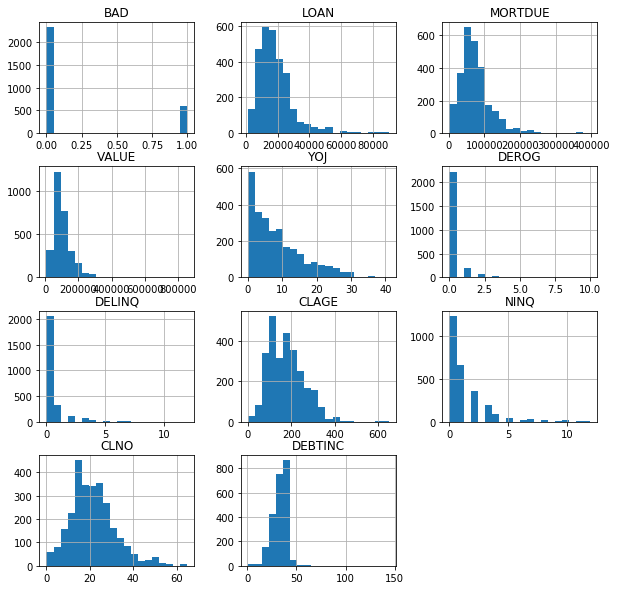

In [34]:
df = df_spark_sample.toPandas()
df.hist(bins=20, figsize=(10,10)) 
plt.show()

<div class="alert-info">
CAS
</div>

In [35]:
conn.sampling.srs(
    table   = "hmeq",
    samppct = 50,
    seed = 12345,
    partind = False,
    output  = dict(casOut = dict(name = 'mysam', replace = True),  copyVars = 'ALL')
)

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=12345 for sampling.


[OutputCasTables]

              casLib   Name Label  Rows  Columns                                      casTable
 0  CASUSER(student)  mysam        2980       13  CASTable('mysam', caslib='CASUSER(student)')

[SRSFreq]

 Frequencies
 
    NObs  NSamp
 0  5960   2980

+ Elapsed: 0.0156s, user: 0.0141s, sys: 0.0129s, mem: 39.2mb

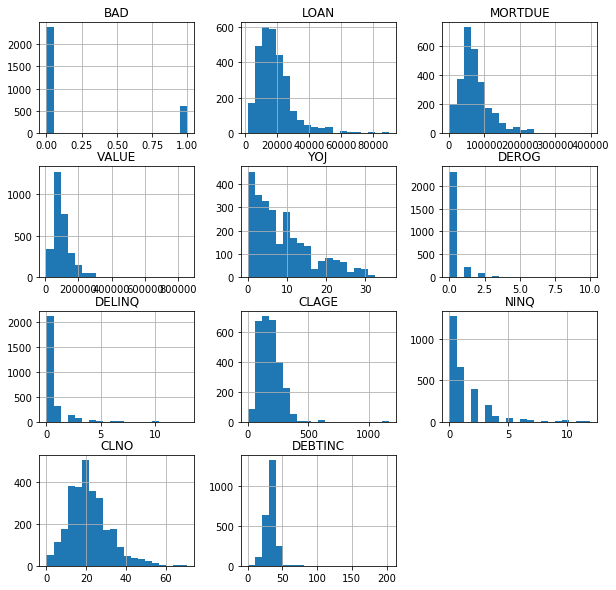

In [36]:
mysam = conn.CASTable(name = "mysam")
df = mysam.to_frame()
df.hist(bins=20, figsize=(10,10))
plt.show()

# Transform Columns

<div class="alert-success">
Spark
</div>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B8A0561F08>,
      dtype=object)

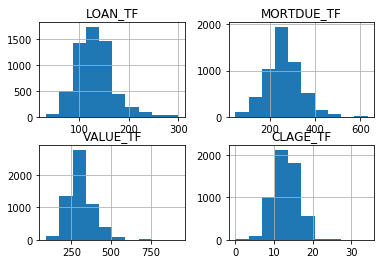

In [37]:
TF_cols = ["LOAN", "MORTDUE", "VALUE", "CLAGE"]
for tf_col in TF_cols:
    df_spark = df_spark.withColumn(tf_col+"_TF", sqrt(tf_col))
    df_spark = df_spark.drop(tf_col)

df_spark.select([x+"_TF" for x in TF_cols]).toPandas().hist()

In [38]:
df_spark = df_spark.withColumn("YOJ_TF", \
                    when((df_spark.YOJ <= 10), lit("<=10")) \
                    .when((df_spark.YOJ > 10) & (df_spark.YOJ <= 20), lit("11-20")) \
                    .when((df_spark.YOJ > 20) & (df_spark.YOJ <= 100), lit(">20")) \
                    .otherwise(lit(None)) \
)

df_spark = df_spark.drop("YOJ")

In [39]:
df_spark.groupBy("YOJ_TF").count().show()

+------+-----+
|YOJ_TF|count|
+------+-----+
|   >20|  557|
|  null|  515|
|  <=10| 3663|
| 11-20| 1225|
+------+-----+



In [40]:
df_spark.columns

['BAD',
 'REASON',
 'JOB',
 'DEROG',
 'DELINQ',
 'NINQ',
 'CLNO',
 'DEBTINC',
 'LOAN_TF',
 'MORTDUE_TF',
 'VALUE_TF',
 'CLAGE_TF',
 'YOJ_TF']

<div class="alert-info">
CAS
</div>

In [41]:
transform_score_code = '''

    LOAN_TF = sqrt(LOAN);
    MORTDUE_TF = sqrt(MORTDUE);
    VALUE_TF = sqrt(VALUE);
    CLAGE_TF = sqrt(CLAGE);
        
    if YOJ <= 10 then YOJ_TF = '< = 10';
    else if YOJ <= 20 then YOJ_TF = '11-20';
    else YOJ_TF = '>20';
    if YOJ = '' then YOJ_TF = '';
    
'''

ds_code = "data hmeq (drop = LOAN MORTDUE VALUE CLAGE YOJ); set hmeq; " + transform_score_code + " run;"
print(ds_code,"\n")

data hmeq (drop = LOAN MORTDUE VALUE CLAGE YOJ); set hmeq; 

    LOAN_TF = sqrt(LOAN);
    MORTDUE_TF = sqrt(MORTDUE);
    VALUE_TF = sqrt(VALUE);
    CLAGE_TF = sqrt(CLAGE);
        
    if YOJ <= 10 then YOJ_TF = '< = 10';
    else if YOJ <= 20 then YOJ_TF = '11-20';
    else YOJ_TF = '>20';
    if YOJ = '' then YOJ_TF = '';
    
 run; 



In [42]:
conn.dataStep.runCode(code=ds_code)

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      1:51
NOTE: Missing values were generated as a result of performing an operation on missing values.
      Each place is given by: (Number of times) at (Line):(Column).
      8 at 0:103    7 at 0:133    10 at 0:161
      23 at 0:103   6 at 0:133    18 at 0:161
      18 at 0:103   5 at 0:133    10 at 0:161
      25 at 0:103   3 at 0:133    17 at 0:161
      22 at 0:103   7 at 0:133    12 at 0:161
      6 at 0:103    13 at 0:161
      73 at 0:103   12 at 0:133   52 at 0:161
      36 at 0:103   6 at 0:133    5 at 0:161
      32 at 0:103   5 at 0:133    21 at 0:161
      45 at 0:103   12 at 0:133   14 at 0:161
      36 at 0:103   3 at 0:133    22 at 0:161
      21 at 0:103   7 at 0:133    20 at 0:161
      30 at 0:103   4 at 0:133    20 at 0:161
      53 at 0:103   12 at 0:133   10 at 0:161
      38 at 0:103   17 at 0:133   26 at 0:161
      52 at 0:103   6 at 0:133    38 at 0:161
NOTE

[InputCasTables]

              casLib  Name  Rows  Columns                                     casTable
 0  CASUSER(student)  hmeq  5960       13  CASTable('hmeq', caslib='CASUSER(student)')

[OutputCasTables]

              casLib  Name  Rows  Columns  Append Promoted                                     casTable
 0  CASUSER(student)  hmeq  5960       13     NaN        N  CASTable('hmeq', caslib='CASUSER(student)')

+ Elapsed: 0.0248s, user: 0.0439s, sys: 0.041s, mem: 10.8mb

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B8A0A96B48>,
      dtype=object)

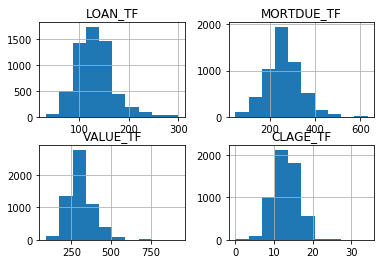

In [43]:
df_cas[["LOAN_TF", "MORTDUE_TF", "VALUE_TF", "CLAGE_TF"]].to_frame().hist()

In [44]:
conn.simple.freq(
    table = "hmeq",
    inputs = "YOJ_TF"
)

,Column,CharVar,FmtVar,Level,Frequency
0,YOJ_TF,,,1,515.0
1,YOJ_TF,< = 10,< = 10,2,3663.0
2,YOJ_TF,>20,>20,3,557.0
3,YOJ_TF,11-20,11-20,4,1225.0


In [45]:
list(df_cas)

['BAD',
 'REASON',
 'JOB',
 'DEROG',
 'DELINQ',
 'NINQ',
 'CLNO',
 'DEBTINC',
 'LOAN_TF',
 'MORTDUE_TF',
 'VALUE_TF',
 'CLAGE_TF',
 'YOJ_TF']

# Transform DATA Step Score Code

<div class="alert-info">
CAS
</div>

In [46]:
df = pd.DataFrame([transform_score_code], columns=['transform_string'])
print(df["transform_string"][0])



    LOAN_TF = sqrt(LOAN);
    MORTDUE_TF = sqrt(MORTDUE);
    VALUE_TF = sqrt(VALUE);
    CLAGE_TF = sqrt(CLAGE);
        
    if YOJ <= 10 then YOJ_TF = '< = 10';
    else if YOJ <= 20 then YOJ_TF = '11-20';
    else YOJ_TF = '>20';
    if YOJ = '' then YOJ_TF = '';
    



In [47]:
np.savetxt("D:\\Workshop\\winsas\\VOSI\\score_code_transform.txt", df.values, fmt="%s")

# Impute Missing

<div class="alert-success">
Spark
</div>

In [48]:
tbl = df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_spark.columns]).toPandas().T
tbl = tbl.reset_index()
tbl.columns = ["Column","NMiss"]
tbl

,Column,NMiss
0,BAD,0
1,REASON,252
2,JOB,279
3,DEROG,708
4,DELINQ,580
5,NINQ,510
6,CLNO,222
7,DEBTINC,1267
8,LOAN_TF,0
9,MORTDUE_TF,518


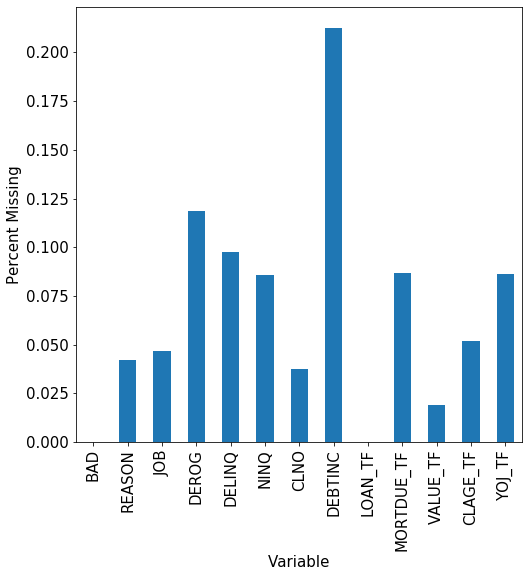

In [49]:
tbl["PctMiss"] = tbl["NMiss"]/df_spark.count()
MissPlot = tbl.plot(x='Column', y='PctMiss', kind='bar', figsize=(8,8), fontsize=15) 
MissPlot.set_xlabel('Variable', fontsize=15) 
MissPlot.set_ylabel('Percent Missing', fontsize=15) 
MissPlot.legend_.remove() 
plt.show()

In [50]:
int_inputs = ['LOAN_TF', 'MORTDUE_TF', 'VALUE_TF', 'DEROG', 'DELINQ', 'CLAGE_TF', 'NINQ', 'CLNO', 'DEBTINC']

for inp in int_inputs:
    med = df_spark.approxQuantile(inp,[0.5],0)[0]
    print("Imputed value for",inp,"is",med)

imputer_int = Imputer(
    inputCols = int_inputs,
    outputCols = ["IMP_{}".format(a) for a in int_inputs]
).setStrategy("median")

df_spark = imputer_int.fit(df_spark).transform(df_spark)

Imputed value for LOAN_TF is 127.67145334803705
Imputed value for MORTDUE_TF is 254.98431324299148
Imputed value for VALUE_TF is 298.715583791673
Imputed value for DEROG is 0.0
Imputed value for DELINQ is 0.0
Imputed value for CLAGE_TF is 13.170674495509598
Imputed value for NINQ is 1.0
Imputed value for CLNO is 20.0
Imputed value for DEBTINC is 34.818261818587


In [51]:
cat_inputs = ['JOB', 'REASON', "YOJ_TF"]
for i in range(len(cat_inputs)):
    df_spark = df_spark.withColumn("IMP_"+cat_inputs[i], df_spark[cat_inputs[i]])
    temp = df_spark.groupBy(cat_inputs[i]).count().toPandas()
    impval = temp.iloc[:,0][np.argmax(temp["count"])]
    print("Imputed value for",cat_inputs[i],"is",impval)
    df_spark = df_spark.na.fill(value=impval, subset=["IMP_"+cat_inputs[i]])

Imputed value for JOB is Other
Imputed value for REASON is DebtCon
Imputed value for YOJ_TF is <=10


In [52]:
df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_spark.columns]).toPandas()

,BAD,REASON,JOB,DEROG,DELINQ,NINQ,CLNO,DEBTINC,LOAN_TF,MORTDUE_TF,VALUE_TF,CLAGE_TF,YOJ_TF,IMP_LOAN_TF,IMP_MORTDUE_TF,IMP_VALUE_TF,IMP_DEROG,IMP_DELINQ,IMP_CLAGE_TF,IMP_NINQ,IMP_CLNO,IMP_DEBTINC,IMP_JOB,IMP_REASON,IMP_YOJ_TF
0,0,252,279,708,580,510,222,1267,0,518,112,308,515,0,0,0,0,0,0,0,0,0,0,0,0


<div class="alert-info">
CAS
</div>

In [53]:
tbl = df_cas.distinct()['Distinct'][['Column', 'NMiss']]
tbl

,Column,NMiss
0,BAD,0.0
1,REASON,252.0
2,JOB,279.0
3,DEROG,708.0
4,DELINQ,580.0
5,NINQ,510.0
6,CLNO,222.0
7,DEBTINC,1267.0
8,LOAN_TF,0.0
9,MORTDUE_TF,518.0


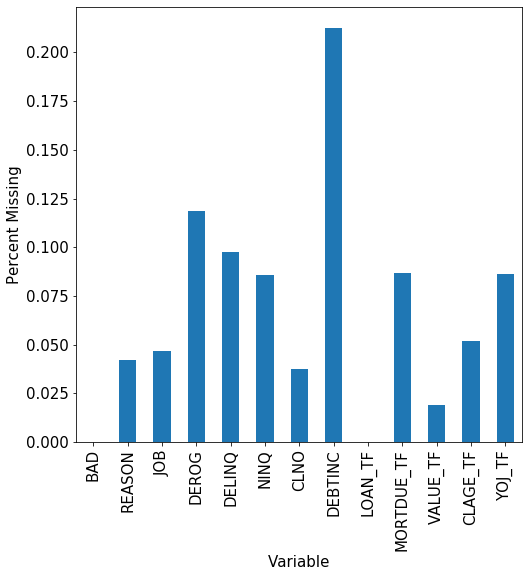

In [54]:
nr = df_cas.shape[0]
tbl['PctMiss'] = tbl['NMiss']/nr
MissPlot = tbl.plot(x='Column', y='PctMiss', kind='bar', figsize=(8,8), fontsize=15)
MissPlot.set_xlabel('Variable', fontsize=15)
MissPlot.set_ylabel('Percent Missing', fontsize=15)
MissPlot.legend_.remove()
plt.show()

In [55]:
conn.dataPreprocess.impute(
    table = "hmeq",
    methodContinuous = 'MEDIAN',
    methodNominal    = 'MODE',
    inputs           = list(df_cas)[1:],
    copyAllVars      = True,
    casOut           = dict(name = "hmeq", replace = True),
    code = dict(casOut = dict(name = "score_code_impute", replace = True))
)

,Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
0,REASON,Mode,IMP_REASON,5708.0,252.0,NaN,DebtCon
1,JOB,Mode,IMP_JOB,5681.0,279.0,NaN,Other
2,DEROG,Median,IMP_DEROG,5252.0,708.0,0.000000,
3,DELINQ,Median,IMP_DELINQ,5380.0,580.0,0.000000,
4,NINQ,Median,IMP_NINQ,5450.0,510.0,1.000000,
5,CLNO,Median,IMP_CLNO,5738.0,222.0,20.000000,
6,DEBTINC,Median,IMP_DEBTINC,4693.0,1267.0,34.818262,
7,LOAN_TF,Median,IMP_LOAN_TF,5960.0,0.0,127.671453,
8,MORTDUE_TF,Median,IMP_MORTDUE_TF,5442.0,518.0,254.988235,
9,VALUE_TF,Median,IMP_VALUE_TF,5848.0,112.0,298.723116,


In [56]:
df_cas.distinct()['Distinct'][['Column', 'NMiss']]

,Column,NMiss
0,BAD,0.0
1,REASON,252.0
2,JOB,279.0
3,DEROG,708.0
4,DELINQ,580.0
5,NINQ,510.0
6,CLNO,222.0
7,DEBTINC,1267.0
8,LOAN_TF,0.0
9,MORTDUE_TF,518.0


# Impute DATA Step Score Code

<div class="alert-info">
CAS
</div>

In [57]:
conn.dataStep.runCode(code='''
    data score_code_impute (keep = DataStepSrc);
        set score_code_impute;
    run;
'''
)

[InputCasTables]

              casLib               Name  Rows  Columns                                                  casTable
 0  CASUSER(student)  score_code_impute     1       10  CASTable('score_code_impute', caslib='CASUSER(student)')

[OutputCasTables]

              casLib               Name  Rows  Columns  Append Promoted                                                  casTable
 0  CASUSER(student)  score_code_impute     1        1     NaN        N  CASTable('score_code_impute', caslib='CASUSER(student)')

+ Elapsed: 0.0166s, user: 0.0221s, sys: 0.0262s, mem: 10.8mb

In [58]:
score_code_impute = conn.CASTable(name = "score_code_impute")
df = score_code_impute.to_frame()
print(df['DataStepSrc'][0])

   _ngbys_ = 1;
   _igby_ = 0;
   _tnn_ntrans_ = 1;

   _fuzcmp_ = 2.22044604925e-10;

   array _tnn_vnames_{9}  _temporary_ ; 
   _tnn_vnames_{1} = IMP_DEROG; 
   _tnn_vnames_{2} = IMP_DELINQ; 
   _tnn_vnames_{3} = IMP_NINQ; 
   _tnn_vnames_{4} = IMP_CLNO; 
   _tnn_vnames_{5} = IMP_DEBTINC; 
   _tnn_vnames_{6} = IMP_LOAN_TF; 
   _tnn_vnames_{7} = IMP_MORTDUE_TF; 
   _tnn_vnames_{8} = IMP_VALUE_TF; 
   _tnn_vnames_{9} = IMP_CLAGE_TF; 

   array _vnn_names_{9} _temporary_; 
   _vnn_names_{1} = CLAGE_TF; 
   _vnn_names_{2} = CLNO; 
   _vnn_names_{3} = DEBTINC; 
   _vnn_names_{4} = DELINQ; 
   _vnn_names_{5} = DEROG; 
   _vnn_names_{6} = LOAN_TF; 
   _vnn_names_{7} = MORTDUE_TF; 
   _vnn_names_{8} = NINQ; 
   _vnn_names_{9} = VALUE_TF; 

   array _tnn_ntransvars_{1}  _temporary_   (9 ); 


   array _tv_nn_indices_{9}  _temporary_   (5 4 8 2 3 6 7 9 1 ); 

   IMP_DEROG = .;
   IMP_DELINQ = .;
   IMP_NINQ = .;
   IMP_CLNO = .;
   IMP_DEBTINC = .;
   IMP_LOAN_TF = .;
   IMP_MORTDUE_TF = .;
 

In [59]:
np.savetxt("D:\\Workshop\\winsas\\VOSI\\score_code_impute.txt", df.values, fmt="%s")

# Get Variables

<div class="alert-success">
Spark
</div>

In [60]:
df_spark.dtypes

[('BAD', 'int'),
 ('REASON', 'string'),
 ('JOB', 'string'),
 ('DEROG', 'int'),
 ('DELINQ', 'int'),
 ('NINQ', 'int'),
 ('CLNO', 'int'),
 ('DEBTINC', 'double'),
 ('LOAN_TF', 'double'),
 ('MORTDUE_TF', 'double'),
 ('VALUE_TF', 'double'),
 ('CLAGE_TF', 'double'),
 ('YOJ_TF', 'string'),
 ('IMP_LOAN_TF', 'double'),
 ('IMP_MORTDUE_TF', 'double'),
 ('IMP_VALUE_TF', 'double'),
 ('IMP_DEROG', 'int'),
 ('IMP_DELINQ', 'int'),
 ('IMP_CLAGE_TF', 'double'),
 ('IMP_NINQ', 'int'),
 ('IMP_CLNO', 'int'),
 ('IMP_DEBTINC', 'double'),
 ('IMP_JOB', 'string'),
 ('IMP_REASON', 'string'),
 ('IMP_YOJ_TF', 'string')]

In [61]:
columns = []
column_type = []
for i in df_spark.dtypes:
    columns.append(i[0])
    column_type.append(i[1])
    
target = columns[0]
inputs_spark = columns[1:]
nom_ind = [i for i, e in enumerate(column_type) if e == "string"]
nominals_spark = [columns[i] for i in nom_ind]

inputs_spark = [k for k in inputs_spark if 'IMP_' in k]
nominals_spark = [k for k in nominals_spark if 'IMP_' in k]

print(target)
print(inputs_spark)
print(nominals_spark)

BAD
['IMP_LOAN_TF', 'IMP_MORTDUE_TF', 'IMP_VALUE_TF', 'IMP_DEROG', 'IMP_DELINQ', 'IMP_CLAGE_TF', 'IMP_NINQ', 'IMP_CLNO', 'IMP_DEBTINC', 'IMP_JOB', 'IMP_REASON', 'IMP_YOJ_TF']
['IMP_JOB', 'IMP_REASON', 'IMP_YOJ_TF']


<div class="alert-info">
CAS
</div>

In [62]:
colinfo = conn.table.columninfo(table="hmeq")['ColumnInfo']
colinfo[["Column","Type"]]

,Column,Type
0,BAD,double
1,REASON,varchar
2,JOB,varchar
3,DEROG,double
4,DELINQ,double
5,NINQ,double
6,CLNO,double
7,DEBTINC,double
8,LOAN_TF,double
9,MORTDUE_TF,double


In [63]:
target = colinfo['Column'][0]

inputs_cas = list(colinfo['Column'][1:])
nominals_cas = list(colinfo.query('Type=="varchar" | Type=="char"')['Column'])

inputs_cas = [k for k in inputs_cas if 'IMP_' in k]
nominals_cas = [k for k in nominals_cas if 'IMP_' in k]
nominals_cas = [target] + nominals_cas

display(target)
display(inputs_cas)
display(nominals_cas)

'BAD'

['IMP_CLAGE_TF',
 'IMP_CLNO',
 'IMP_DEBTINC',
 'IMP_DELINQ',
 'IMP_DEROG',
 'IMP_LOAN_TF',
 'IMP_MORTDUE_TF',
 'IMP_NINQ',
 'IMP_VALUE_TF',
 'IMP_JOB',
 'IMP_REASON',
 'IMP_YOJ_TF']

['BAD', 'IMP_JOB', 'IMP_REASON', 'IMP_YOJ_TF']

# Dummy Code Nominals

<div class="alert-success">
Spark
</div>

In [64]:
for nominal in nominals_spark:
    print(nominal)
    
    # String Indexing
    str_ind = StringIndexer().setInputCol(nominal).setOutputCol(nominal+"_Index")
    nom_index = str_ind.fit(df_spark)
    df_spark = nom_index.transform(df_spark)
    df_spark.crosstab(nominal, nominal+"_Index").show()
    
    # One Hot Encoding
    encoder = OneHotEncoder().setInputCol(nominal+"_Index").setOutputCol(nominal+"_Encoder")
    encoder_fit = encoder.fit(df_spark)
    df_spark = encoder_fit.transform(df_spark)
    
    print(df_spark.sample(withReplacement=False, fraction=5/df_spark.count(), seed=802).toPandas()[[nominal,nominal+"_Index",nominal+"_Encoder"]])
    print("\n")

IMP_JOB
+---------------------+----+----+---+---+---+---+
|IMP_JOB_IMP_JOB_Index| 0.0| 1.0|2.0|3.0|4.0|5.0|
+---------------------+----+----+---+---+---+---+
|                Other|2667|   0|  0|  0|  0|  0|
|                Sales|   0|   0|  0|  0|  0|109|
|                 Self|   0|   0|  0|  0|193|  0|
|              ProfExe|   0|1276|  0|  0|  0|  0|
|                  Mgr|   0|   0|  0|767|  0|  0|
|               Office|   0|   0|948|  0|  0|  0|
+---------------------+----+----+---+---+---+---+

   IMP_JOB  IMP_JOB_Index            IMP_JOB_Encoder
0  ProfExe            1.0  (0.0, 1.0, 0.0, 0.0, 0.0)
1    Other            0.0  (1.0, 0.0, 0.0, 0.0, 0.0)
2   Office            2.0  (0.0, 0.0, 1.0, 0.0, 0.0)


IMP_REASON
+---------------------------+----+----+
|IMP_REASON_IMP_REASON_Index| 0.0| 1.0|
+---------------------------+----+----+
|                    DebtCon|4180|   0|
|                    HomeImp|   0|1780|
+---------------------------+----+----+

  IMP_REASON  IMP_REASON_

In [65]:
inputs_spark = [x for x in inputs_spark if x not in nominals_spark]
nominals_spark = [x+"_Encoder" for x in nominals_spark]
inputs_spark = inputs_spark + nominals_spark

print(inputs_spark)
print(nominals_spark)

['IMP_LOAN_TF', 'IMP_MORTDUE_TF', 'IMP_VALUE_TF', 'IMP_DEROG', 'IMP_DELINQ', 'IMP_CLAGE_TF', 'IMP_NINQ', 'IMP_CLNO', 'IMP_DEBTINC', 'IMP_JOB_Encoder', 'IMP_REASON_Encoder', 'IMP_YOJ_TF_Encoder']
['IMP_JOB_Encoder', 'IMP_REASON_Encoder', 'IMP_YOJ_TF_Encoder']


<div class="alert-info">
CAS
</div>

In [66]:
None

# Vector Assembler

<div class="alert-success">
Spark
</div>

In [67]:
vector_col = "vec_features"
assembler = VectorAssembler(inputCols=inputs_spark, outputCol=vector_col)
df_spark = assembler.transform(df_spark)

In [68]:
df_spark.limit(5).toPandas()[inputs_spark+[vector_col]]

,IMP_LOAN_TF,IMP_MORTDUE_TF,IMP_VALUE_TF,IMP_DEROG,IMP_DELINQ,IMP_CLAGE_TF,IMP_NINQ,IMP_CLNO,IMP_DEBTINC,IMP_JOB_Encoder,IMP_REASON_Encoder,IMP_YOJ_TF_Encoder,vec_features
0,33.166248,160.810447,197.547463,0,0,9.714251,1,9,34.802429,"(1.0, 0.0, 0.0, 0.0, 0.0)",(0.0),"(0.0, 1.0)","(33.166247903554, 160.81044742180154, 197.5474626513841, 0.0, 0.0, 9.714250700217011, 1.0, 9.0, 34.802428777084, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
1,36.055513,264.675273,261.533937,0,2,11.037814,0,14,34.802429,"(1.0, 0.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0)","(36.05551275463989, 264.6752727400125, 261.5339366124404, 0.0, 2.0, 11.03781379319895, 0.0, 14.0, 34.802428777084, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)"
2,38.729833,116.189500,129.228480,0,0,12.225656,1,10,34.802429,"(1.0, 0.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0)","(38.72983346207417, 116.1895003862225, 129.22847983320085, 0.0, 0.0, 12.225656083281052, 1.0, 10.0, 34.802428777084, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)"
3,38.729833,254.950976,298.571599,0,0,13.165042,1,20,34.802429,"(1.0, 0.0, 0.0, 0.0, 0.0)",(1.0),"(1.0, 0.0)","(38.72983346207417, 254.95097567963924, 298.5715994531295, 0.0, 0.0, 13.165041615991724, 1.0, 20.0, 34.802428777084, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0)"
4,41.231056,312.729915,334.664011,0,0,9.660918,0,14,34.802429,"(0.0, 0.0, 1.0, 0.0, 0.0)",(0.0),"(1.0, 0.0)","(41.23105625617661, 312.7299154222378, 334.66401061363024, 0.0, 0.0, 9.660917830792958, 0.0, 14.0, 34.802428777084, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0)"


<div class="alert-info">
CAS
</div>

In [69]:
None

# Partition Data

<div class="alert-success">
Spark
</div>

In [70]:
train, test = df_spark.randomSplit([0.7, 0.3], seed=802)
print("Train Obs", train.count())
print("Test Obs", test.count())
print("Total Obs", df_spark.count())

Train Obs 4152
Test Obs 1808
Total Obs 5960


<div class="alert-info">
CAS
</div>

In [71]:
conn.sampling.srs(
    table   = "hmeq",
    samppct = 70,
    seed = 919,
    partind = True,
    output  = dict(casOut = dict(name = "hmeq", replace = True),  copyVars = 'ALL')
)

print("Train Obs", sum(df_cas["_PartInd_"]==1))
print("Test Obs", sum(df_cas["_PartInd_"]==0))
print("Total Obs", df_cas.shape[0])

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=919 for sampling.
Train Obs 4172.0
Test Obs 1788.0
Total Obs 5960


# Logistic Regression

<div class="alert-success">
Spark
</div>

In [72]:
lr = LogisticRegression(featuresCol=vector_col, labelCol=target)
lr_model = lr.fit(train)
lr_preds_test = lr_model.transform(test)
lr_preds_test.select(target,"probability","prediction").limit(5).toPandas()

,BAD,probability,prediction
0,0,"[0.8307812855931831, 0.1692187144068169]",0.0
1,0,"[0.8473826343967285, 0.15261736560327155]",0.0
2,0,"[0.8240510484038909, 0.17594895159610913]",0.0
3,0,"[0.885607346733571, 0.114392653266429]",0.0
4,0,"[0.8841438236422733, 0.11585617635772671]",0.0


In [73]:
TP = lr_preds_test.filter( (lr_preds_test.BAD==1) & (lr_preds_test.prediction==1) ).count()
TN = lr_preds_test.filter( (lr_preds_test.BAD==0) & (lr_preds_test.prediction==0) ).count()
FP = lr_preds_test.filter( (lr_preds_test.BAD==0) & (lr_preds_test.prediction==1) ).count()
FN = lr_preds_test.filter( (lr_preds_test.BAD==1) & (lr_preds_test.prediction==0) ).count()

conf_mat_spark = pd.DataFrame([["Logistic Regression Spark",TP,TN,FP,FN]], columns = ["Model","TP","TN","FP","FN"])
conf_mat_spark

,Model,TP,TN,FP,FN
0,Logistic Regression Spark,108,1434,42,224


In [74]:
lr_acc = MulticlassClassificationEvaluator(labelCol=target).setMetricName("accuracy").evaluate(lr_preds_test)
lr_auc = BinaryClassificationEvaluator(labelCol=target).setMetricName("areaUnderROC").evaluate(lr_preds_test)
lr_metrics_spark = pd.DataFrame([["Logistic Regression Spark", 1-lr_acc, lr_auc]], columns=["Model", "Misclassification", "Area Under Curve"])
lr_metrics_spark

,Model,Misclassification,Area Under Curve
0,Logistic Regression Spark,0.147124,0.800609


<div class="alert-info">
CAS
</div>

In [75]:
lr_model = conn.regression.logistic(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    classVars = nominals_cas[1:],
    model = dict(depvar=target, effects=inputs_cas, dist='binomial', link='logit'),
    store    = dict(name='lr_model',replace=True)
)

NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: 476415 bytes were written to the table "lr_model" in the caslib "CASUSER(student)".


In [76]:
lr_score = conn.regression.logisticScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 0'),
    restore = "lr_model",
    casout = dict(name="lr_scored", replace=True),
    copyVars = target
)

In [77]:
conn.table.fetch(table="lr_scored", to=5)["Fetch"]

,_PRED_,BAD
0,0.392781,1.0
1,0.615918,1.0
2,0.277568,1.0
3,0.194729,1.0
4,0.391753,1.0


In [78]:
lr_assess = conn.percentile.assess(
   table = 'lr_scored',
   inputs = "_PRED_",
   casout = dict(name="lr_assess",replace=True),
   response = target,
   event = "1"
)

display(conn.table.fetch(table="lr_assess", to=3))
conn.table.fetch(table="lr_assess_ROC", to=3)

,_Column_,_Event_,_Depth_,_Value_,_NObs_,_NEvents_,_NEventsBest_,_Resp_,_RespBest_,_Lift_,_LiftBest_,_CumResp_,_CumRespBest_,_CumLift_,_CumLiftBest_,_PctResp_,_PctRespBest_,_CumPctResp_,_CumPctRespBest_,_Gain_,_GainBest_
0,_PRED_,1,5.0,0.677364,90.0,76.0,90.0,22.619048,26.785714,4.523810,5.357143,22.619048,26.785714,4.523810,5.357143,84.444444,100.0,84.444444,100.0,3.523810,4.357143
1,_PRED_,1,10.0,0.452561,90.0,44.0,90.0,13.095238,26.785714,2.619048,5.357143,35.714286,53.571429,3.571429,5.357143,48.888889,100.0,66.666667,100.0,2.571429,4.357143
2,_PRED_,1,15.0,0.345102,90.0,36.0,90.0,10.714286,26.785714,2.142857,5.357143,46.428571,80.357143,3.095238,5.357143,40.000000,100.0,57.777778,100.0,2.095238,4.357143


,_Column_,_Event_,_Cutoff_,_TP_,_FP_,_FN_,_TN_,_Sensitivity_,_Specificity_,_KS_,_KS2_,_FHALF_,_FPR_,_ACC_,_FDR_,_F1_,_C_,_GINI_,_GAMMA_,_TAU_,_MiscEvent_
0,_PRED_,1,0.00,336.0,1452.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.224359,1.000000,0.187919,0.812081,0.316384,0.796834,0.593668,0.603661,0.181296,0.812081
1,_PRED_,1,0.01,336.0,1444.0,0.0,8.0,1.0,0.005510,0.0,0.005510,0.225322,0.994490,0.192394,0.811236,0.317580,0.796834,0.593668,0.603661,0.181296,0.807606
2,_PRED_,1,0.02,336.0,1423.0,0.0,29.0,1.0,0.019972,0.0,0.019972,0.227889,0.980028,0.204139,0.808982,0.320764,0.796834,0.593668,0.603661,0.181296,0.795861


In [79]:
lr_assess_ROC = conn.CASTable(name = "lr_assess_ROC")
lr_assess_ROC = lr_assess_ROC.to_frame()
lr_assess_ROC['Model'] = 'Logistic Regression CAS'
cutoff_index = round(lr_assess_ROC['_Cutoff_'],2)==0.5
lr_assess_ROC = lr_assess_ROC[cutoff_index].reset_index(drop=True)
conf_mat_cas = lr_assess_ROC[['Model','_TP_','_FP_','_FN_','_TN_']]
conf_mat_cas

,Model,_TP_,_FP_,_FN_,_TN_
0,Logistic Regression CAS,110.0,40.0,226.0,1412.0


In [80]:
lr_metrics_cas = pd.DataFrame([["Logistic Regression CAS", 1-lr_assess_ROC['_ACC_'][0], lr_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
lr_metrics_cas

,Model,Misclassification,Area Under Curve
0,Logistic Regression CAS,0.14877,0.796834


# Decision Tree

<div class="alert-success">
Spark
</div>

In [81]:
dt = DecisionTreeClassifier(featuresCol=vector_col, labelCol=target, seed=802)
dt_model = dt.fit(train)
dt_preds_test = dt_model.transform(test)

In [82]:
dt_acc = MulticlassClassificationEvaluator(labelCol=target).setMetricName("accuracy").evaluate(dt_preds_test)
dt_auc = BinaryClassificationEvaluator(labelCol=target).setMetricName("areaUnderROC").evaluate(dt_preds_test)
dt_metrics_spark = pd.DataFrame([["Decision Tree Spark", 1-dt_acc, dt_auc]], columns=["Model", "Misclassification", "Area Under Curve"])
dt_metrics_spark

,Model,Misclassification,Area Under Curve
0,Decision Tree Spark,0.123341,0.63551


<div class="alert-info">
CAS
</div>

In [83]:
dt_model = conn.decisionTree.dtreeTrain(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs_cas, 
    nominals = nominals_cas,
    casOut   = dict(name = 'dt_model', replace = True)
)

In [84]:
dt_score = conn.decisionTree.dtreeScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 0'),
    model = "dt_model",
    casout = dict(name="dt_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

In [85]:
dt_assess = conn.percentile.assess(
   table = "dt_scored",
   inputs = "P_BAD1",
   casout = dict(name="dt_assess",replace=True),
   response = target,
   event = "1"
)

In [86]:
dt_assess_ROC = conn.CASTable(name = "dt_assess_ROC")
dt_assess_ROC = dt_assess_ROC.to_frame()
cutoff_index = round(dt_assess_ROC['_Cutoff_'],2)==0.5
dt_assess_ROC = dt_assess_ROC[cutoff_index].reset_index(drop=True)
dt_metrics_cas = pd.DataFrame([["Decision Tree CAS", 1-dt_assess_ROC['_ACC_'][0], dt_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
dt_metrics_cas

,Model,Misclassification,Area Under Curve
0,Decision Tree CAS,0.145414,0.645698


# Random Forest

<div class="alert-success">
Spark
</div>

In [87]:
rf = RandomForestClassifier(featuresCol=vector_col, labelCol=target, seed=802)
rf_model = rf.fit(train)
rf_preds_test = rf_model.transform(test)

In [88]:
rf_acc = MulticlassClassificationEvaluator(labelCol=target).setMetricName("accuracy").evaluate(rf_preds_test)
rf_auc = BinaryClassificationEvaluator(labelCol=target).setMetricName("areaUnderROC").evaluate(rf_preds_test)
rf_metrics_spark = pd.DataFrame([["Random Forest Spark", 1-rf_acc, rf_auc]], columns=["Model", "Misclassification", "Area Under Curve"])
rf_metrics_spark

,Model,Misclassification,Area Under Curve
0,Random Forest Spark,0.121681,0.903421


<div class="alert-info">
CAS
</div>

In [89]:
rf_model = conn.decisionTree.forestTrain(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs_cas, 
    nominals = nominals_cas,
    casOut   = dict(name = 'rf_model', replace = True)
)

In [90]:
rf_score = conn.decisionTree.forestScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 0'),
    model = "rf_model",
    casout = dict(name="rf_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

In [91]:
rf_assess = conn.percentile.assess(
   table = "rf_scored",
   inputs = "P_BAD1",
   casout = dict(name="rf_assess",replace=True),
   response = target,
   event = "1"
)

In [92]:
rf_assess_ROC = conn.CASTable(name = "rf_assess_ROC")
rf_assess_ROC = rf_assess_ROC.to_frame()
cutoff_index = round(rf_assess_ROC['_Cutoff_'],2)==0.5
rf_assess_ROC = rf_assess_ROC[cutoff_index].reset_index(drop=True)
rf_metrics_cas = pd.DataFrame([["Random Forest CAS", 1-rf_assess_ROC['_ACC_'][0], rf_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
rf_metrics_cas

,Model,Misclassification,Area Under Curve
0,Random Forest CAS,0.151007,0.849429


# Gradient Boosting

<div class="alert-success">
Spark
</div>

In [93]:
gb = GBTClassifier(featuresCol=vector_col, labelCol=target, seed=802)
gb_model = gb.fit(train)
gb_preds_test = gb_model.transform(test)

In [94]:
gb_acc = MulticlassClassificationEvaluator(labelCol=target).setMetricName("accuracy").evaluate(gb_preds_test)
gb_auc = BinaryClassificationEvaluator(labelCol=target).setMetricName("areaUnderROC").evaluate(gb_preds_test)
gb_metrics_spark = pd.DataFrame([["Gradient Boosting Spark", 1-gb_acc, gb_auc]], columns=["Model", "Misclassification", "Area Under Curve"])
gb_metrics_spark

,Model,Misclassification,Area Under Curve
0,Gradient Boosting Spark,0.110066,0.922169


<div class="alert-info">
CAS
</div>

In [95]:
gb_model = conn.decisionTree.gbtreeTrain(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs_cas, 
    nominals = nominals_cas,
    casOut   = dict(name = 'gb_model', replace = True)
)

In [96]:
gb_score = conn.decisionTree.gbtreeScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 0'),
    model = "gb_model",
    casout = dict(name="gb_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

In [97]:
gb_assess = conn.percentile.assess(
   table = "gb_scored",
   inputs = "P_BAD1",
   casout = dict(name="gb_assess",replace=True),
   response = target,
   event = "1"
)

In [98]:
gb_assess_ROC = conn.CASTable(name = "gb_assess_ROC")
gb_assess_ROC = gb_assess_ROC.to_frame()
cutoff_index = round(gb_assess_ROC['_Cutoff_'],2)==0.5
gb_assess_ROC = gb_assess_ROC[cutoff_index].reset_index(drop=True)
gb_metrics_cas = pd.DataFrame([["Gradient Boosting CAS", 1-gb_assess_ROC['_ACC_'][0], gb_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
gb_metrics_cas

,Model,Misclassification,Area Under Curve
0,Gradient Boosting CAS,0.112975,0.916942


# Hyperparameter Tuning

<div class="alert-success">
Spark
</div>

In [99]:
all_models_spark = pd.concat([lr_metrics_spark, dt_metrics_spark, rf_metrics_spark, gb_metrics_spark])
all_models_spark.sort_values('Misclassification').reset_index(drop=True)

,Model,Misclassification,Area Under Curve
0,Gradient Boosting Spark,0.110066,0.922169
1,Random Forest Spark,0.121681,0.903421
2,Decision Tree Spark,0.123341,0.635510
3,Logistic Regression Spark,0.147124,0.800609


In [100]:
param_grid = ParamGridBuilder()\
                .addGrid(gb.maxDepth, [5, 10, 15])\
                .addGrid(gb.maxBins, [25, 50, 75])\
                .addGrid(gb.minInstancesPerNode, [10])\
                .addGrid(gb.stepSize, [0.1])\
                .build()

evaluator = MulticlassClassificationEvaluator(labelCol=target).setMetricName("accuracy")
gb_tune = TrainValidationSplit(estimator=gb, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8, seed=802)

gb_tune_model = gb_tune.fit(train)
gb_tune_preds_test = gb_tune_model.transform(test)

In [101]:
print("Tuned Max Depth =", gb_tune_model.bestModel.getMaxDepth())
print("Tuned Max Bins", gb_tune_model.bestModel.getMaxBins())

gb_tune_acc = MulticlassClassificationEvaluator(labelCol=target).setMetricName("accuracy").evaluate(gb_tune_preds_test)
gb_tune_auc = BinaryClassificationEvaluator(labelCol=target).setMetricName("areaUnderROC").evaluate(gb_tune_preds_test)
gb_tune_metrics_spark = pd.DataFrame([["Tuned Gradient Boosting Spark", 1-gb_tune_acc, gb_tune_auc]], columns=["Model", "Misclassification", "Area Under Curve"])
all_models_spark = pd.concat([all_models_spark, gb_tune_metrics_spark])
all_models_spark.sort_values('Misclassification').reset_index(drop=True)

Tuned Max Depth = 10
Tuned Max Bins 50


,Model,Misclassification,Area Under Curve
0,Tuned Gradient Boosting Spark,0.102876,0.928036
1,Gradient Boosting Spark,0.110066,0.922169
2,Random Forest Spark,0.121681,0.903421
3,Decision Tree Spark,0.123341,0.635510
4,Logistic Regression Spark,0.147124,0.800609


<div class="alert-info">
CAS
</div>

In [102]:
all_models_cas = pd.concat([lr_metrics_cas, dt_metrics_cas, rf_metrics_cas, gb_metrics_cas])
all_models_cas.sort_values('Misclassification').reset_index(drop=True)

,Model,Misclassification,Area Under Curve
0,Gradient Boosting CAS,0.112975,0.916942
1,Decision Tree CAS,0.145414,0.645698
2,Logistic Regression CAS,0.148770,0.796834
3,Random Forest CAS,0.151007,0.849429


In [103]:
gb_tune_model = conn.autotune.tuneGradientBoostTree(
    trainOptions = dict(
        table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
        target   = target, 
        inputs   = inputs_cas, 
        nominals = nominals_cas,
        casOut   = dict(name = 'gb_tune_model', replace = True) ) ,
    tunerOptions = dict(seed = 802, maxEvals = 10, maxTime = 30, searchmethod='GA', objective="MCE")
)

gb_tune_model["BestConfiguration"]

NOTE: Autotune is started for 'Gradient Boosting Tree' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=10.
NOTE: Autotune option MAXTIME=30 (sec.).
NOTE: Autotune option SEED=802.
NOTE: Autotune objective is 'Misclassification'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
NOTE: Automatic early stopping is activated with STAGNATION=4;  set EARLYSTOP=false to deactivate.
         Iteration       Evals     Best Objective  Elapsed Time
                 0           1              0.119          0.45
                 1          25             0.0879         12.32
NOTE: Data was partitioned during tuning, to tune based on validation score; the final model is trained and scored on all data.
NOTE: The number of trees used in the final model is 114.
NOTE: Autotune time is 14.06 seconds.


,Parameter,Name,Value
0,Evaluation,Evaluation,5
1,Number of Variables to Try,M,8
2,Learning Rate,LEARNINGRATE,0.34
3,Sampling Rate,SUBSAMPLERATE,0.5
4,Lasso,LASSO,1.11111111
5,Ridge,RIDGE,1.11111111
6,Number of Bins,NBINS,91
7,Maximum Tree Levels,MAXLEVEL,7
8,Misclassification,Objective,0.0878594249


In [104]:
gb_tune_score = conn.decisionTree.gbtreeScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 0'),
    model = "gb_tune_model",
    casout = dict(name="gb_tune_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

In [105]:
gb_tune_assess = conn.percentile.assess(
   table = "gb_tune_scored",
   inputs = "P_BAD1",
   casout = dict(name="gb_tune_assess",replace=True),
   response = target,
   event = "1"
)

In [106]:
gb_tune_assess_ROC = conn.CASTable(name = "gb_tune_assess_ROC")
gb_tune_assess_ROC = gb_tune_assess_ROC.to_frame()
cutoff_index = round(gb_tune_assess_ROC['_Cutoff_'],2)==0.5
gb_tune_assess_ROC = gb_tune_assess_ROC[cutoff_index].reset_index(drop=True)
gb_tune_metrics_cas = pd.DataFrame([["Tuned Gradient Boosting CAS", 1-gb_tune_assess_ROC['_ACC_'][0], gb_tune_assess_ROC['_C_'][0]]], columns=["Model", "Misclassification", "Area Under Curve"])
all_models_cas = pd.concat([all_models_cas, gb_tune_metrics_cas])
all_models_cas.sort_values('Misclassification').reset_index(drop=True)

,Model,Misclassification,Area Under Curve
0,Tuned Gradient Boosting CAS,0.086689,0.950120
1,Gradient Boosting CAS,0.112975,0.916942
2,Decision Tree CAS,0.145414,0.645698
3,Logistic Regression CAS,0.148770,0.796834
4,Random Forest CAS,0.151007,0.849429


# Save Champion

In [107]:
all_models = pd.concat([all_models_spark, all_models_cas])
all_models.sort_values('Misclassification').reset_index(drop=True)

,Model,Misclassification,Area Under Curve
0,Tuned Gradient Boosting CAS,0.086689,0.950120
1,Tuned Gradient Boosting Spark,0.102876,0.928036
2,Gradient Boosting Spark,0.110066,0.922169
3,Gradient Boosting CAS,0.112975,0.916942
4,Random Forest Spark,0.121681,0.903421
5,Decision Tree Spark,0.123341,0.635510
6,Decision Tree CAS,0.145414,0.645698
7,Logistic Regression Spark,0.147124,0.800609
8,Logistic Regression CAS,0.148770,0.796834
9,Random Forest CAS,0.151007,0.849429


<div class="alert-success">
Spark
</div>

In [108]:
None

<div class="alert-info">
CAS
</div>

In [109]:
conn.table.addCaslib(name="mycl", path="/workshop/winsas/VOSI", dataSource="PATH", activeOnAdd=False)

NOTE: Cloud Analytic Services added the caslib 'mycl'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,mycl,PATH,,/workshop/winsas/VOSI/,,0.0,1.0,0.0,0.0,0.0,0.0


In [110]:
conn.table.save(caslib = 'mycl', table = dict(name = 'gb_tune_model'), name = 'gb_tune_model', replace = True)

NOTE: Cloud Analytic Services saved the file gb_tune_model.sashdat in caslib mycl.


[caslib]

 'mycl'

[name]

 'gb_tune_model.sashdat'

+ Elapsed: 0.0118s, user: 0.00148s, sys: 0.00617s, mem: 16.6mb

In [111]:
conn.table.attribute(caslib = 'CASUSER', table = 'gb_tune_attr', name = 'gb_tune_model', task='convert')
conn.table.save(caslib = 'mycl', table = 'gb_tune_attr', name = 'gb_tune_attr', replace = True)

NOTE: Cloud Analytic Services saved the file gb_tune_attr.sashdat in caslib mycl.


[caslib]

 'mycl'

[name]

 'gb_tune_attr.sashdat'

+ Elapsed: 0.00402s, user: 0.00149s, sys: 0.000252s, mem: 16.5mb

# Load Champion

<div class="alert-info">
CAS
</div>

In [112]:
# conn.table.addCaslib(name="mycl", path="/workshop/winsas/VOSI", dataSource="PATH", activeOnAdd=False)

In [113]:
# conn.table.loadTable(caslib = 'mycl', path="gb_tune_model.sashdat", casOut=dict(name="gb_tune_model", replace=True))

In [114]:
# conn.table.loadTable(caslib = 'mycl', path="gb_tune_attr.sashdat", casOut=dict(name="gb_tune_attr", replace=True))
# conn.table.attribute(caslib='CASUSER(student)', task='ADD', name='gb_tune_model', attrtable='gb_tune_attr')

# Model Data Step Score Code

<div class="alert-info">
CAS
</div>

In [115]:
conn.decisionTree.gbtreeCode(
    modelTable = "gb_tune_model",
    code = dict(casOut = dict(name = "score_code_model", replace = True))
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(student),score_code_model,1,10,"CASTable('score_code_model', caslib='CASUSER(student)')"


In [116]:
conn.dataStep.runCode(code='''
    data score_code_model (keep = DataStepSrc);
        set score_code_model;
    run;
'''
)

[InputCasTables]

              casLib              Name  Rows  Columns                                                 casTable
 0  CASUSER(student)  score_code_model     1       10  CASTable('score_code_model', caslib='CASUSER(student)')

[OutputCasTables]

              casLib              Name  Rows  Columns  Append Promoted                                                 casTable
 0  CASUSER(student)  score_code_model     1        1     NaN        N  CASTable('score_code_model', caslib='CASUSER(student)')

+ Elapsed: 0.0243s, user: 0.0334s, sys: 0.0283s, mem: 12mb

In [117]:
score_code_model = conn.CASTable(name = "score_code_model")
df = score_code_model.to_frame()
print(df['DataStepSrc'][0][:100000])

   length _strfmt_ $7; drop _strfmt_;
   _strfmt_ = ' ';

   array _leaf_id_207174495_{114} _temporary_;

   array _tlevname_207174495_{2} $12 _temporary_ ( '           1' 
   '           0');


   _initpred_ =     1.35865926422829;
   _sumx_  = 0;


   _node_id_ =  0;
   _new_id_  = -1;
   nextnode_tree_207174495_0:
   if _node_id_ eq 0 then do;

         _numval_ = IMP_DELINQ;
         if missing(_numval_) then do;
            _numval_ = -1.7976931348623E308;
         end;
         if (_numval_ ge 0 and _numval_ lt 1) then do;


            _new_id_ = 1;
         end;
         else if (_numval_ ge 1 and _numval_ lt 15) then do;

            _new_id_ = 2;
         end;
         else if (_numval_ lt 0) then do;

            _new_id_ = 1;
         end;
         else if (_numval_ ge 15) then do;
            _new_id_ = 2;
         end;
         else do;
         _new_id_ = 1;
         end;
   end;

   else if _node_id_ eq 1 then do;
         _numval_ = IMP_DEBTINC;
         if missing(_nu

In [118]:
np.savetxt("D:\\Workshop\\winsas\\VOSI\\score_code_model.txt", df.values, fmt="%s")

# Using the SAS DATA Step Score Code Pipeline

<div class="alert-info">
CAS
</div>

In [119]:
sas_studio = '''

/**********/
/*Get Data*/
/**********/

libname mycas cas;
libname local '/home/student';

data mycas.hmeq; 
    set local.hmeq; 
run;

proc surveyselect data=mycas.hmeq method=srs n=500 out=mycas.hmeq_sample;
run;

proc contents data=mycas.hmeq_sample;
run;

/************/
/*Score Data*/
/************/

filename sfile1 '/home/student/score_code_transform.txt';
filename sfile2 '/home/student/score_code_impute.txt';
filename sfile3 '/home/student/score_code_model.txt';

data mycas.scored;
    set mycas.hmeq_sample;
    %include sfile1;
    %include sfile2;
    %include sfile3;
run;

proc contents data=mycas.scored;
run;

/**************/
/*View Results*/
/**************/

proc freq data=mycas.scored;
    table bad*gbt_bad;
run;

data mycas.scored;
    set mycas.scored;
    TPTN = bad = gbt_bad;
run;

proc means data=mycas.scored mean;
    var TPTN;
run;

'''

# End Session

<div class="alert-success">
Spark
</div>

In [120]:
spark.stop()

<div class="alert-info">
CAS
</div>

In [121]:
conn.session.endSession()

+ Elapsed: 0.000263s, sys: 0.000236s, mem: 0.208mb